In [8]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns
from agent import *
from selection import update_convergence_episode
from utils import *
from component import Environment
from simulation import construct_agent, TwoAgentSimulation
from main import Config
from tqdm import tqdm

In [9]:
seed_everything()
torch.cuda.is_available()

True

# PD

In [10]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=20)

In [11]:
# choices = {'0-alwaysCooperate','1-alwaysDefect','2-titForTat','3-reverseTitForTat','4-random','5-grudger','6-pavlov','7-qLearning','8-lstm-TFT','9-dqn','10-lstmqn','11-a2c','12-a2c-lstm'}
# rl_choices = {'7-qLearning','8-lstm-pavlov','9-dqn','10-lstmqn','11-a2c','12-a2c-lstm'}
strategies = {0:'ALLC',1:'ALLD',2:'TitForTat',3:'revTitForTat',4:'Random',5:'Grudger',6:'Pavlov',7:'QLearning',8:'LSTM',9:'DQN',10:'LSTMQN',11:'A2C',12:'A2CLSTM'}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed_everything()
config = {
    'reward': 3, 
    'sucker': 0, 
    'temptation': 5, 
    'punishment': 1, 
    'n_episodes': 10000, 
    'discount': 0.99,
    'play_epsilon': 1,
    'select_epsilon': 1,
    'epsilon_decay': 0.995,
    'min_epsilon': 0.01,
    'alpha': 0.1,
    'n_actions': 2,
    'h': 5,
    'select_h': 5,
    'state_repr': 'bi',
    'batch_size': 64,
    'learning_rate': 1e-3,
}

df = pd.DataFrame(columns=['agent1_strategy_converge', 'agent1_reward_converge', 'agent1_network_converge', 
                            'temptation', 'reward', 'punishment', 'sucker', 
                            'agent1_final_strategy', 'agent1_defection_ratio', 'loss',
                            'agent1_playing_times', 'model', 'opponent', 'h', 'epsilon_decay', 'game'])

In [12]:
def check_convergence(agents: dict[int, object], thresh: tuple, k: int, last_reward: dict[int, float], test_state: Type.TensorType, test_q_dict: dict, count: int):
    strategy_convergent_episode = {}
    reward_convergent_episode = {}
    network_convergent_episode = {}
    thresh_strategy, thresh_reward, thresh_network = thresh[0], thresh[1], thresh[2]

    for n in agents:
        # Strategy convergence
        strategy_convergent = agents[n].determine_convergence(thresh_strategy, k)
        if strategy_convergent:
            strategy_convergent_episode[n] = agents[n].play_times

        # reward convergence
        if np.abs(agents[n].running_score-last_reward[n]) <= thresh_reward:
            reward_convergent_episode[n] = agents[n].play_times
        
        # network convergence
        with torch.no_grad():
            test_q_dict[n][count] = agents[n].policy_net(test_state).to('cpu').detach().numpy()
        diff = np.sum(np.diff(test_q_dict[n][count])) - np.sum(np.diff(test_q_dict[n][count-1])) if count>1 else np.inf

        if np.abs(diff) <= thresh_network:
            network_convergent_episode[n] = agents[n].play_times
    return strategy_convergent_episode, reward_convergent_episode, network_convergent_episode

In [13]:
h = [1,2,5,7,10]
epsilon_decay = [0.95, 0.99, 0.995]
num = 2
k = 1000

thresh_strategy = 15
thresh_reward = 2

### DQN vs TfT

In [14]:
rl_num = 9

for i in h:
    for j in epsilon_decay:
        config['h'] = i
        config['epsilon_decay'] = j
        print(f'config: h={i}, epsilon_decay={j}')

        for idx, val in tqdm(enumerate(reward)):
            config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
        
            config_obj = Config(config)
            with HiddenPrints():
            # if True:
                env = Environment(config_obj)
                agent1 = construct_agent(strategies[num], config_obj)
                agent2 = construct_agent(strategies[rl_num], config_obj)
                agents = {}
                agents[1] = agent2   

                test_state_list = generate_state(agent2, config_obj.h, config_obj.n_actions)
                test_state = torch.stack(list(test_state_list), dim=0).view(len(test_state_list), -1).to(device)
                # test_state = torch.stack(test_state_list, dim=0).view(len(test_state_list), config_obj.h, -1).to(device)
                for n in agents:
                    test_q_dict = {n: {}}
                thresh_network = len(test_state_list)/10
                thresh = (thresh_strategy, thresh_reward, thresh_network)

                count = 0
                convergent_episode_dict = {'strategy':{}, 'reward':{}, 'network':{}}
                
                while True:
                    last_reward = {}
                    last_reward[1] = agents[1].running_score

                    env.play(agent1, agent2, k)
                    strategy_convergent_episode, reward_convergent_episode, network_convergent_episode = check_convergence(
                        agents, thresh, k, last_reward, test_state, test_q_dict, count)
                    count += 1
                    update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
                    update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
                    update_convergence_episode(convergent_episode_dict, 'network', network_convergent_episode)

                    if count*k >= config_obj.n_episodes:
                        break

                    converge = []
                    for key, _ in convergent_episode_dict.items():
                        converge.append(len(convergent_episode_dict[key]) == len(agents))
                    if sum(converge) > 2:
                        break
                
                for key, v in convergent_episode_dict.items():
                    if 1 not in list(v.keys()):
                        convergent_episode_dict[key][1] = np.nan
            
            df.loc[len(df.index)]= [convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], convergent_episode_dict['network'][1], 
                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                    float(torch.sum(agent2.own_memory)/agent2.play_times), np.mean(agent2.loss),
                                    agent2.play_times, agent2.name, agent1.name, config['h'], config['epsilon_decay'], 'PD']

        # print(f'playing times: {agent2.play_times}')
        # print(f'length of loss: {len(agent2.loss)}, average of loss (interval is 2): {np.mean(agent2.loss[::2])}, average of loss (interval is 20): {np.mean(agent2.loss[::20])}, average of loss (interval is 100): {np.mean(agent2.loss[::100])}')
        # agent2.show()
        # print()
        # print()
        
    # plt.plot(agent2.loss[::20])
    # plt.title(f'agent:{agent2.name}')
    # plt.show()
# x = [i for i in range(0, agent1.play_times)]
# plt.figure(figsize=(20, 10))
# plt.plot(x, agent1.own_memory[0:agent1.play_times], label=agent1.name, alpha=0.5)
# plt.plot(x, agent2.own_memory[0:agent2.play_times], label=agent2.name, alpha=0.5)
# plt.legend()
# plt.ylim(-0.5, 2)
# plt.xlim(0, agent1.play_times)
# plt.title(f'agent:{agent1.name} vs agent:{agent2.name}')
# plt.savefig(f'images/{agent1.name}vs{agent2.name}_result_h={config.h}.png')
# plt.show()

config: h=1, epsilon_decay=0.95


20it [05:19, 15.99s/it]


config: h=1, epsilon_decay=0.99


20it [10:47, 32.36s/it]


config: h=1, epsilon_decay=0.995


20it [07:56, 23.83s/it]


config: h=2, epsilon_decay=0.95


20it [10:04, 30.22s/it]


config: h=2, epsilon_decay=0.99


20it [08:41, 26.07s/it]


config: h=2, epsilon_decay=0.995


20it [09:44, 29.21s/it]


config: h=5, epsilon_decay=0.95


20it [10:19, 30.96s/it]


config: h=5, epsilon_decay=0.99


20it [10:39, 32.00s/it]


config: h=5, epsilon_decay=0.995


20it [11:18, 33.90s/it]


config: h=7, epsilon_decay=0.95


20it [10:03, 30.16s/it]


config: h=7, epsilon_decay=0.99


20it [09:16, 27.83s/it]


config: h=7, epsilon_decay=0.995


20it [10:38, 31.93s/it]


config: h=10, epsilon_decay=0.95


20it [10:07, 30.36s/it]


config: h=10, epsilon_decay=0.99


20it [10:27, 31.38s/it]


config: h=10, epsilon_decay=0.995


20it [10:46, 32.30s/it]


### DRQN vs TfT

In [15]:
rl_num = 10

for i in h:
    for j in epsilon_decay:
        config['h'] = i
        config['epsilon_decay'] = j
        print(f'config: h={i}, epsilon_decay={j}')

        for idx, val in tqdm(enumerate(reward)):
            config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
        
            config_obj = Config(config)
            with HiddenPrints():
            # if True:
                env = Environment(config_obj)
                agent1 = construct_agent(strategies[num], config_obj)
                agent2 = construct_agent(strategies[rl_num], config_obj)
                agents = {}
                agents[1] = agent2   

                test_state_list = generate_state(agent2, config_obj.h, config_obj.n_actions)
                # test_state = torch.stack(list(test_state_list), dim=0).view(len(test_state_list), -1).to(device)
                test_state = torch.stack(test_state_list, dim=0).view(len(test_state_list), config_obj.h, -1).to(device)
                for n in agents:
                    test_q_dict = {n: {}}
                thresh_network = len(test_state_list)/10
                thresh = (thresh_strategy, thresh_reward, thresh_network)

                count = 0
                convergent_episode_dict = {'strategy':{}, 'reward':{}, 'network':{}}
                
                while True:
                    last_reward = {}
                    last_reward[1] = agents[1].running_score

                    env.play(agent1, agent2, k)
                    strategy_convergent_episode, reward_convergent_episode, network_convergent_episode = check_convergence(
                        agents, thresh, k, last_reward, test_state, test_q_dict, count)
                    count += 1
                    update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
                    update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
                    update_convergence_episode(convergent_episode_dict, 'network', network_convergent_episode)

                    if count*k >= config_obj.n_episodes:
                        break

                    converge = []
                    for key, _ in convergent_episode_dict.items():
                        converge.append(len(convergent_episode_dict[key]) == len(agents))
                    if sum(converge) > 2:
                        break
                
                for key, v in convergent_episode_dict.items():
                    if 1 not in list(v.keys()):
                        convergent_episode_dict[key][1] = np.nan
            
            df.loc[len(df.index)]= [convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], convergent_episode_dict['network'][1], 
                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                    float(torch.sum(agent2.own_memory)/agent2.play_times), np.mean(agent2.loss),
                                    agent2.play_times, agent2.name, agent1.name, config['h'], config['epsilon_decay'], 'PD']

config: h=1, epsilon_decay=0.95


20it [11:13, 33.65s/it]


config: h=1, epsilon_decay=0.99


20it [06:48, 20.42s/it]


config: h=1, epsilon_decay=0.995


20it [05:55, 17.80s/it]


config: h=2, epsilon_decay=0.95


20it [14:02, 42.13s/it]


config: h=2, epsilon_decay=0.99


20it [10:52, 32.62s/it]


config: h=2, epsilon_decay=0.995


20it [07:02, 21.11s/it]


config: h=5, epsilon_decay=0.95


20it [11:09, 33.48s/it]


config: h=5, epsilon_decay=0.99


20it [10:38, 31.91s/it]


config: h=5, epsilon_decay=0.995


20it [08:53, 26.67s/it]


config: h=7, epsilon_decay=0.95


20it [13:29, 40.45s/it]


config: h=7, epsilon_decay=0.99


20it [1:07:35, 202.80s/it] 


config: h=7, epsilon_decay=0.995


20it [09:50, 29.53s/it]


config: h=10, epsilon_decay=0.95


20it [12:00, 36.00s/it]


config: h=10, epsilon_decay=0.99


20it [10:44, 32.21s/it]


config: h=10, epsilon_decay=0.995


20it [09:38, 28.93s/it]


# SH

In [16]:
reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=20)

### DQN vs TfT

In [17]:
rl_num = 9
k = 1000

# reward, temptation, sucker, punishment = [3], [5], [0], [1]
for i in h:
    for j in epsilon_decay:
        config['h'] = i
        config['epsilon_decay'] = j
        print(f'config: h={i}, epsilon_decay={j}')

        for idx, val in tqdm(enumerate(reward)):
            config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
        
            config_obj = Config(config)
            with HiddenPrints():
            # if True:
                env = Environment(config_obj)
                agent1 = construct_agent(strategies[num], config_obj)
                agent2 = construct_agent(strategies[rl_num], config_obj)
                agents = {}
                agents[1] = agent2   

                test_state_list = generate_state(agent2, config_obj.h, config_obj.n_actions)
                test_state = torch.stack(list(test_state_list), dim=0).view(len(test_state_list), -1).to(device)
                # test_state = torch.stack(test_state_list, dim=0).view(len(test_state_list), config_obj.h, -1).to(device)
                for n in agents:
                    test_q_dict = {n: {}}
                thresh_network = len(test_state_list)/10
                thresh = (thresh_strategy, thresh_reward, thresh_network)

                count = 0
                convergent_episode_dict = {'strategy':{}, 'reward':{}, 'network':{}}
                
                while True:
                    last_reward = {}
                    last_reward[1] = agents[1].running_score

                    env.play(agent1, agent2, k)
                    strategy_convergent_episode, reward_convergent_episode, network_convergent_episode = check_convergence(
                        agents, thresh, k, last_reward, test_state, test_q_dict, count)
                    count += 1
                    update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
                    update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
                    update_convergence_episode(convergent_episode_dict, 'network', network_convergent_episode)

                    if count*k >= config_obj.n_episodes:
                        break

                    converge = []
                    for key, _ in convergent_episode_dict.items():
                        converge.append(len(convergent_episode_dict[key]) == len(agents))
                    if sum(converge) > 2:
                        break
                
                for key, v in convergent_episode_dict.items():
                    if 1 not in list(v.keys()):
                        convergent_episode_dict[key][1] = np.nan
            
            df.loc[len(df.index)]= [convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], convergent_episode_dict['network'][1], 
                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                    float(torch.sum(agent2.own_memory)/agent2.play_times), np.mean(agent2.loss),
                                    agent2.play_times, agent2.name, agent1.name, config['h'], config['epsilon_decay'], 'SH']

config: h=1, epsilon_decay=0.95


20it [08:15, 24.77s/it]


config: h=1, epsilon_decay=0.99


20it [09:27, 28.39s/it]


config: h=1, epsilon_decay=0.995


20it [07:47, 23.37s/it]


config: h=2, epsilon_decay=0.95


20it [09:42, 29.15s/it]


config: h=2, epsilon_decay=0.99


20it [08:44, 26.23s/it]


config: h=2, epsilon_decay=0.995


20it [09:18, 27.92s/it]


config: h=5, epsilon_decay=0.95


20it [09:57, 29.89s/it]


config: h=5, epsilon_decay=0.99


20it [09:23, 28.15s/it]


config: h=5, epsilon_decay=0.995


20it [3:15:49, 587.47s/it]


config: h=7, epsilon_decay=0.95


20it [11:39, 34.97s/it]


config: h=7, epsilon_decay=0.99


20it [11:21, 34.07s/it]


config: h=7, epsilon_decay=0.995


20it [11:15, 33.78s/it]


config: h=10, epsilon_decay=0.95


20it [11:34, 34.75s/it]


config: h=10, epsilon_decay=0.99


20it [11:35, 34.78s/it]


config: h=10, epsilon_decay=0.995


20it [12:04, 36.23s/it]


### DRQN vs TfT

In [18]:
rl_num = 10

for i in h:
    for j in epsilon_decay:
        config['h'] = i
        config['epsilon_decay'] = j
        print(f'config: h={i}, epsilon_decay={j}')

        for idx, val in tqdm(enumerate(reward)):
            config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
        
            config_obj = Config(config)
            with HiddenPrints():
            # if True:
                env = Environment(config_obj)
                agent1 = construct_agent(strategies[num], config_obj)
                agent2 = construct_agent(strategies[rl_num], config_obj)
                agents = {}
                agents[1] = agent2   

                test_state_list = generate_state(agent2, config_obj.h, config_obj.n_actions)
                # test_state = torch.stack(list(test_state_list), dim=0).view(len(test_state_list), -1).to(device)
                test_state = torch.stack(test_state_list, dim=0).view(len(test_state_list), config_obj.h, -1).to(device)
                for n in agents:
                    test_q_dict = {n: {}}
                thresh_network = len(test_state_list)/10
                thresh = (thresh_strategy, thresh_reward, thresh_network)

                count = 0
                convergent_episode_dict = {'strategy':{}, 'reward':{}, 'network':{}}
                
                while True:
                    last_reward = {}
                    last_reward[1] = agents[1].running_score

                    env.play(agent1, agent2, k)
                    strategy_convergent_episode, reward_convergent_episode, network_convergent_episode = check_convergence(
                        agents, thresh, k, last_reward, test_state, test_q_dict, count)
                    count += 1
                    update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
                    update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
                    update_convergence_episode(convergent_episode_dict, 'network', network_convergent_episode)

                    if count*k >= config_obj.n_episodes:
                        break

                    converge = []
                    for key, _ in convergent_episode_dict.items():
                        converge.append(len(convergent_episode_dict[key]) == len(agents))
                    if sum(converge) > 2:
                        break
                
                for key, v in convergent_episode_dict.items():
                    if 1 not in list(v.keys()):
                        convergent_episode_dict[key][1] = np.nan
            
            df.loc[len(df.index)]= [convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], convergent_episode_dict['network'][1], 
                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                    float(torch.sum(agent2.own_memory)/agent2.play_times), np.mean(agent2.loss),
                                    agent2.play_times, agent2.name, agent1.name, config['h'], config['epsilon_decay'], 'SH']

config: h=1, epsilon_decay=0.95


20it [14:52, 44.64s/it]


config: h=1, epsilon_decay=0.99


20it [13:04, 39.23s/it]


config: h=1, epsilon_decay=0.995


20it [11:31, 34.58s/it]


config: h=2, epsilon_decay=0.95


20it [14:13, 42.69s/it]


config: h=2, epsilon_decay=0.99


20it [13:22, 40.13s/it]


config: h=2, epsilon_decay=0.995


20it [12:03, 36.15s/it]


config: h=5, epsilon_decay=0.95


20it [13:27, 40.40s/it]


config: h=5, epsilon_decay=0.99


20it [11:32, 34.64s/it]


config: h=5, epsilon_decay=0.995


20it [13:53, 41.66s/it]


config: h=7, epsilon_decay=0.95


20it [19:17, 57.89s/it]


config: h=7, epsilon_decay=0.99


20it [17:53, 53.66s/it]


config: h=7, epsilon_decay=0.995


20it [19:39, 58.96s/it]


config: h=10, epsilon_decay=0.95


20it [19:53, 59.69s/it]


config: h=10, epsilon_decay=0.99


20it [15:33, 46.66s/it]


config: h=10, epsilon_decay=0.995


20it [12:35, 37.76s/it]


In [21]:
df.to_csv('data/fix_vs_learner.csv')

EDA

--- Game: PD ---
--- DQN ---
h=1, epsion_decay=0.95
Diveregence: Strategy: 4 Reward: 2 Network: 3
Convergence: Strategy: 4000.0 Reward: 3333.3333333333335 Network: 3941.176470588235
h=1, epsion_decay=0.99
Diveregence: Strategy: 19 Reward: 5 Network: 15
Convergence: Strategy: 3000.0 Reward: 7000.0 Network: 8200.0
h=1, epsion_decay=0.995
Diveregence: Strategy: 10 Reward: 4 Network: 10
Convergence: Strategy: 3900.0 Reward: 4937.5 Network: 4300.0
h=2, epsion_decay=0.95
Diveregence: Strategy: 14 Reward: 3 Network: 14
Convergence: Strategy: 7000.0 Reward: 7294.117647058823 Network: 6333.333333333333
h=2, epsion_decay=0.99
Diveregence: Strategy: 12 Reward: 6 Network: 11
Convergence: Strategy: 6000.0 Reward: 4642.857142857143 Network: 5555.555555555556
h=2, epsion_decay=0.995
Diveregence: Strategy: 19 Reward: 7 Network: 17
Convergence: Strategy: 3000.0 Reward: 4230.7692307692305 Network: 8000.0
h=5, epsion_decay=0.95
Diveregence: Strategy: 11 Reward: 5 Network: 10
Convergence: Strategy: 6777.7

C:\Users\HHhou\AppData\Local\Temp\ipykernel_9756\4237518304.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_result.dropna(inplace=True)


--- LSTMQN ---
h=1, epsion_decay=0.95
Diveregence: Strategy: 1 Reward: 0 Network: 0
Convergence: Strategy: 6684.210526315789 Reward: 2750.0 Network: 6650.0
h=1, epsion_decay=0.99
Diveregence: Strategy: 0 Reward: 0 Network: 0
Convergence: Strategy: 3000.0 Reward: 2000.0 Network: 4000.0
h=1, epsion_decay=0.995
Diveregence: Strategy: 0 Reward: 0 Network: 0
Convergence: Strategy: 3000.0 Reward: 2000.0 Network: 4000.0
h=2, epsion_decay=0.95
Diveregence: Strategy: 0 Reward: 2 Network: 1
Convergence: Strategy: 8850.0 Reward: 5944.444444444444 Network: 8157.894736842105
h=2, epsion_decay=0.99
Diveregence: Strategy: 1 Reward: 0 Network: 0
Convergence: Strategy: 6473.684210526316 Reward: 3150.0 Network: 6400.0
h=2, epsion_decay=0.995
Diveregence: Strategy: 0 Reward: 0 Network: 0
Convergence: Strategy: 3750.0 Reward: 2250.0 Network: 4300.0
h=5, epsion_decay=0.95
Diveregence: Strategy: 3 Reward: 1 Network: 2
Convergence: Strategy: 6470.588235294118 Reward: 3000.0 Network: 6444.444444444444
h=5, ep

C:\Users\HHhou\AppData\Local\Temp\ipykernel_9756\4237518304.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_result.dropna(inplace=True)


--- Game: SH ---
--- DQN ---
h=1, epsion_decay=0.95
Diveregence: Strategy: 2 Reward: 9 Network: 3
Convergence: Strategy: 6833.333333333333 Reward: 4090.909090909091 Network: 6117.64705882353
h=1, epsion_decay=0.99
Diveregence: Strategy: 4 Reward: 9 Network: 5
Convergence: Strategy: 7687.5 Reward: 5090.909090909091 Network: 6533.333333333333
h=1, epsion_decay=0.995
Diveregence: Strategy: 0 Reward: 9 Network: 2
Convergence: Strategy: 6450.0 Reward: 2909.090909090909 Network: 5611.111111111111
h=2, epsion_decay=0.95
Diveregence: Strategy: 6 Reward: 12 Network: 8
Convergence: Strategy: 8000.0 Reward: 6500.0 Network: 7416.666666666667
h=2, epsion_decay=0.99
Diveregence: Strategy: 1 Reward: 11 Network: 2
Convergence: Strategy: 7473.684210526316 Reward: 3111.1111111111113 Network: 6944.444444444444
h=2, epsion_decay=0.995
Diveregence: Strategy: 5 Reward: 10 Network: 4
Convergence: Strategy: 7400.0 Reward: 4500.0 Network: 7250.0
h=5, epsion_decay=0.95
Diveregence: Strategy: 2 Reward: 13 Networ

C:\Users\HHhou\AppData\Local\Temp\ipykernel_9756\4237518304.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_result.dropna(inplace=True)


--- LSTMQN ---
h=1, epsion_decay=0.95
Diveregence: Strategy: 0 Reward: 15 Network: 4
Convergence: Strategy: 9100.0 Reward: 5000.0 Network: 8687.5
h=1, epsion_decay=0.99
Diveregence: Strategy: 0 Reward: 9 Network: 0
Convergence: Strategy: 6900.0 Reward: 4272.727272727273 Network: 6700.0
h=1, epsion_decay=0.995
Diveregence: Strategy: 0 Reward: 9 Network: 0
Convergence: Strategy: 6600.0 Reward: 3363.6363636363635 Network: 6250.0
h=2, epsion_decay=0.95
Diveregence: Strategy: 0 Reward: 10 Network: 2
Convergence: Strategy: 8000.0 Reward: 5500.0 Network: 7333.333333333333
h=2, epsion_decay=0.99
Diveregence: Strategy: 0 Reward: 10 Network: 1
Convergence: Strategy: 7400.0 Reward: 4500.0 Network: 6684.210526315789
h=2, epsion_decay=0.995
Diveregence: Strategy: 0 Reward: 9 Network: 0
Convergence: Strategy: 6600.0 Reward: 3363.6363636363635 Network: 6300.0
h=5, epsion_decay=0.95
Diveregence: Strategy: 0 Reward: 8 Network: 3
Convergence: Strategy: 5750.0 Reward: 4666.666666666667 Network: 7235.2941

C:\Users\HHhou\AppData\Local\Temp\ipykernel_9756\4237518304.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_result.dropna(inplace=True)


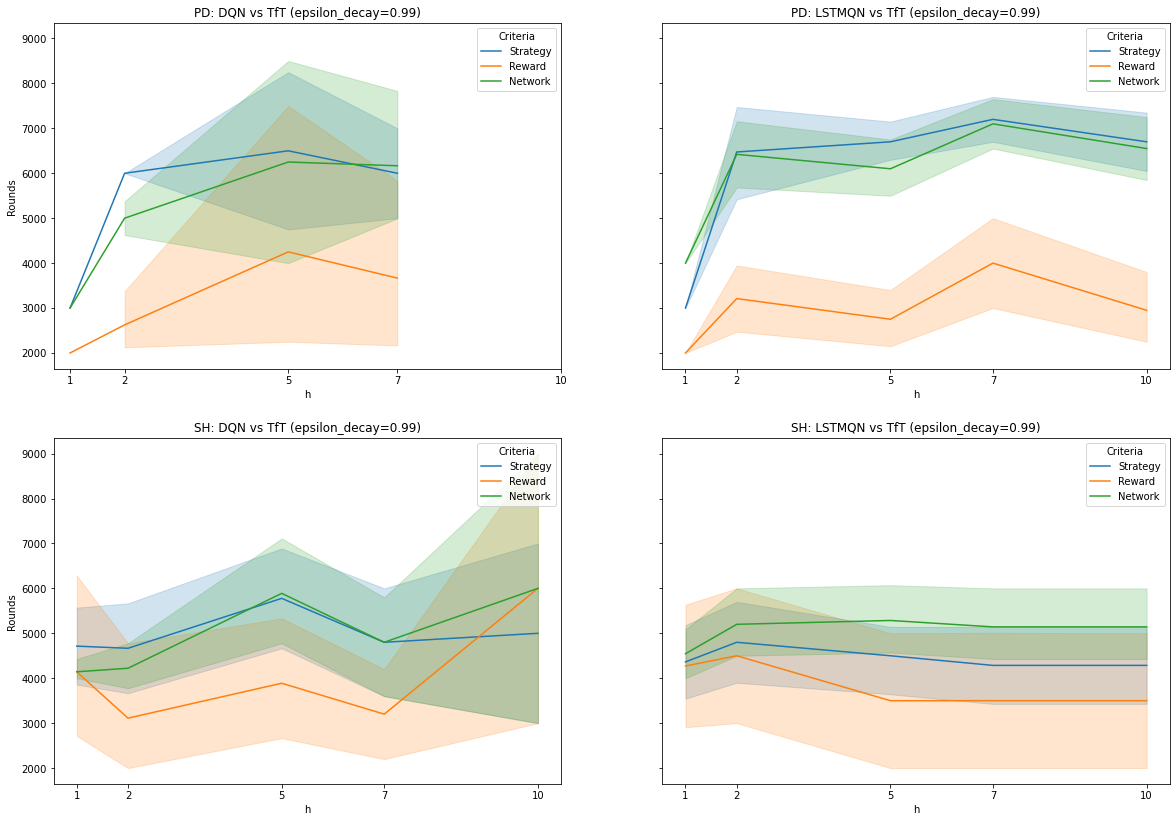

In [25]:
pd.set_option('display.max_rows', None)
# display(df)
df_copy = copy.deepcopy(df)
df_copy.loc[df_copy.isna().any(axis=1), 'agent1_final_strategy'] = -1
fig, axes = plt.subplots(2, 2, figsize=(20, 14), sharey=True)
# fig.tight_layout(rect=[0, 0.03, 1, 0.97])
c = 0
position = np.array([(0,0), (0,1), (1,0), (1,1)])

for game in ['PD', 'SH']:
    print(f'--- Game: {game} ---')
    df_copy_game = df_copy.loc[df_copy.game == game]
    for model in ['DQN', 'LSTMQN']:
        print(f'--- {model} ---')
        df_copy_result = df_copy_game.loc[df_copy_game.model == model]
        for i in h:
            for j in epsilon_decay:
                print(f'h={i}, epsion_decay={j}')
                print(f'Diveregence: Strategy: {df_copy_result.loc[(df_copy_result.h==i) & (df_copy_result.epsilon_decay==j), "agent1_strategy_converge"].isna().sum()}',end=' ')
                print(f'Reward: {df_copy_result.loc[(df_copy_result.h==i) & (df_copy_result.epsilon_decay==j), "agent1_reward_converge"].isna().sum()}',end=' ')
                print(f'Network: {df_copy_result.loc[(df_copy_result.h==i) & (df_copy_result.epsilon_decay==j), "agent1_network_converge"].isna().sum()}')
                print(f'Convergence: Strategy: {df_copy_result.loc[(df_copy_result.h==i) & (df_copy_result.epsilon_decay==j) & (df_copy_result.agent1_strategy_converge.notna()), "agent1_strategy_converge"].mean()}',end=' ')
                print(f'Reward: {df_copy_result.loc[(df_copy_result.h==i) & (df_copy_result.epsilon_decay==j) & (df_copy_result.agent1_reward_converge.notna()), "agent1_reward_converge"].mean()}',end=' ')
                print(f'Network: {df_copy_result.loc[(df_copy_result.h==i) & (df_copy_result.epsilon_decay==j) & (df_copy_result.agent1_network_converge.notna()), "agent1_network_converge"].mean()}')
        print()
        df_copy_result.dropna(inplace=True)
        # plt.figure(figsize=(14, 7))
        p = position[c]
        sns.lineplot(ax=axes[p[0],p[1]], data=df_copy_result.loc[df_copy_result.epsilon_decay==0.99], x='h', y='agent1_strategy_converge', label=f'Strategy')
        sns.lineplot(ax=axes[p[0],p[1]], data=df_copy_result.loc[df_copy_result.epsilon_decay==0.99], x='h', y='agent1_reward_converge', label=f'Reward')
        sns.lineplot(ax=axes[p[0],p[1]], data=df_copy_result.loc[df_copy_result.epsilon_decay==0.99], x='h', y='agent1_network_converge', label=f'Network')
        axes[p[0],p[1]].set(xticks=h, ylabel='Rounds', title=f'{game}: {model} vs TfT (epsilon_decay=0.99)')
        axes[p[0],p[1]].legend(title='Criteria')
        c += 1

# sns.lineplot(ax=axes[1], data=df_copy_result.loc[df_copy_result.h==2], x='epsilon_decay', y='agent1_strategy_converge', label=f'Strategy')
# sns.lineplot(ax=axes[1], data=df_copy_result.loc[df_copy_result.h==2], x='epsilon_decay', y='agent1_reward_converge', label=f'Reward')
# sns.lineplot(ax=axes[1], data=df_copy_result.loc[df_copy_result.h==2], x='epsilon_decay', y='agent1_network_converge', label=f'Network')
# axes[1].set(xticks=[0.95, 0.99, 0.995], ylabel='Rounds', title='DQN vs TfT (h=2)')

## DQN vs DQN

In [ ]:
# epsilon_dict = {'epsilon_decay=0.95':[],'epsilon_decay=0.99':[],'epsilon_decay=0.995':[]}
# result_dict={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
# loss_dict={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
# strategy_dict={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
                
# for key in result_dict:
#     result_dict[key] = copy.deepcopy(epsilon_dict)
#     loss_dict[key] = copy.deepcopy(epsilon_dict)
#     strategy_dict[key] = copy.deepcopy(epsilon_dict)

In [7]:
result_dict_dqn={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
loss_dict_dqn={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
strategy_dict_dqn={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}

for key in result_dict_dqn:
    result_dict_dqn[key] = copy.deepcopy(epsilon_dict)
    loss_dict_dqn[key] = copy.deepcopy(epsilon_dict)
    strategy_dict_dqn[key] = copy.deepcopy(epsilon_dict)

for i in h:
    for j in epsilon_decay:
        config['h'] = i
        config['epsilon_decay'] = j
        config_ob = Config(config)
        env = Environment(config_ob)
        print(f'config: h={i}, epsilon_decay={j}')
        
        rl_num = 9
        for _ in range(5):
            convergence = False
            with HiddenPrints():
                agent1 = constructAgent(strategies[rl_num], config_ob)
                agent2 = constructAgent(strategies[rl_num], config_ob)

                k = 1000
                while not convergence:
                    env.play(agent1, agent2, k)
                    convergence = determine_convergence(agent2, 20, k=k)
                    if agent2.play_times >= 20*k:
                        break
        
                result_dict_dqn[f'h={i}'][f'epsilon_decay={j}'].append(agent2.play_times)
                loss_dict_dqn[f'h={i}'][f'epsilon_decay={j}'].append([np.mean(agent1.loss),np.mean(agent2.loss)])
                strategy_dict_dqn[f'h={i}'][f'epsilon_decay={j}'].append([agent1.own_memory[agent1.play_times-10:agent1.play_times].numpy().astype(int).tolist(), agent2.own_memory[agent2.play_times-10:agent2.play_times].numpy().astype(int).tolist()])
        print(f'playing times: {agent2.play_times}')
        print(f'length of loss: {len(agent1.loss)}, average of loss (interval is 2): {np.mean(agent1.loss[::2])}, average of loss (interval is 20): {np.mean(agent1.loss[::20])}, average of loss (interval is 100): {np.mean(agent1.loss[::100])}')
        print(f'length of loss: {len(agent2.loss)}, average of loss (interval is 2): {np.mean(agent2.loss[::2])}, average of loss (interval is 20): {np.mean(agent2.loss[::20])}, average of loss (interval is 100): {np.mean(agent2.loss[::100])}')
        agent2.show()
        print()
        print()

config: h=1, epsilon_decay=0.95
playing times: 6000
length of loss: 5936, average of loss (interval is 2): 16.66003415278756, average of loss (interval is 20): 16.415073569776233, average of loss (interval is 100): 15.694142721096675
length of loss: 5936, average of loss (interval is 2): 7.205223576020138, average of loss (interval is 20): 7.050136550257503, average of loss (interval is 100): 7.05993527273337
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


config: h=1, epsilon_decay=0.99
playing times: 20000
length of loss: 19936, average of loss (interval is 2): 3.765200049057304, average of loss (interval is 20): 3.766812394022822, average of loss (interval is 100): 3.842576918378472
length of loss: 19936, average of loss (interval is 2): 8.724930017325706, average of loss (interval is 20): 8.81258524953058, average of loss (int

playing times: 4000
length of loss: 3927, average of loss (interval is 2): 39.74156008666863, average of loss (interval is 20): 39.14970471350675, average of loss (interval is 100): 38.4372915238142
length of loss: 3927, average of loss (interval is 2): 53.9493605391314, average of loss (interval is 20): 55.327261114483555, average of loss (interval is 100): 57.51042265892029
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


config: h=10, epsilon_decay=0.99
playing times: 4000
length of loss: 3927, average of loss (interval is 2): 92.06164374024951, average of loss (interval is 20): 92.61497359106383, average of loss (interval is 100): 90.12103570997715
length of loss: 3927, average of loss (interval is 2): 83.13210276840539, average of loss (interval is 20): 84.06750825667744, average of loss (interval is 100): 88.4

In [8]:
result_dict_dqn

{'h=1': {'epsilon_decay=0.95': [20000, 20000, 3000, 3000, 6000],
  'epsilon_decay=0.99': [20000, 20000, 3000, 20000, 20000],
  'epsilon_decay=0.995': [4000, 20000, 20000, 8000, 16000],
  'epsilon_decay=0.999': [20000, 20000, 20000, 20000, 20000]},
 'h=2': {'epsilon_decay=0.95': [3000, 3000, 2000, 3000, 3000],
  'epsilon_decay=0.99': [20000, 4000, 8000, 3000, 11000],
  'epsilon_decay=0.995': [4000, 20000, 18000, 5000, 6000],
  'epsilon_decay=0.999': [20000, 20000, 20000, 20000, 20000]},
 'h=5': {'epsilon_decay=0.95': [20000, 8000, 3000, 5000, 5000],
  'epsilon_decay=0.99': [3000, 6000, 8000, 4000, 9000],
  'epsilon_decay=0.995': [20000, 8000, 8000, 20000, 9000],
  'epsilon_decay=0.999': [20000, 7000, 20000, 20000, 6000]},
 'h=10': {'epsilon_decay=0.95': [3000, 4000, 10000, 20000, 4000],
  'epsilon_decay=0.99': [3000, 5000, 19000, 4000, 4000],
  'epsilon_decay=0.995': [6000, 5000, 3000, 3000, 3000],
  'epsilon_decay=0.999': [20000, 6000, 9000, 15000, 9000]}}

In [9]:
strategy_dict_dqn

{'h=1': {'epsilon_decay=0.95': [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]],
   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]],
  'epsilon_decay=0.99': [[[1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],
  'epsilon_decay=0.995': [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
   [[1, 0, 1, 0, 1, 0, 1, 0, 1, 0], [1, 0, 1, 0, 1, 0, 1, 1, 1, 1]],
   [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
   [[0, 0, 0, 0

In [10]:
for i in h:
    for j in epsilon_decay:
        print(np.mean(np.array(loss_dict_dqn[f'h={i}'][f'epsilon_decay={j}'])[:,0]))

10.36281814012781
5.30305792075878
8.368344093669322
6.437139419724933
16.61400641145889
22.313856821682563
25.244923164907213
9.55751421001342
33.46241106023884
36.018553720553626
22.911297939896606
33.22744478771189
34.79207039937955
68.35792606106725
41.8682668179988
41.587205091281305


## DRQN vs TfT

In [11]:
result_dict_drqn_t={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
loss_dict_drqn_t={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
strategy_dict_drqn_t={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}

for key in result_dict_drqn_t:
    result_dict_drqn_t[key] = copy.deepcopy(epsilon_dict)
    loss_dict_drqn_t[key] = copy.deepcopy(epsilon_dict)
    strategy_dict_drqn_t[key] = copy.deepcopy(epsilon_dict)

for i in h:
    for j in epsilon_decay:
        config['h'] = i
        config['epsilon_decay'] = j
        config_ob = Config(config)
        env = Environment(config_ob)
        print(f'config: h={i}, epsilon_decay={j}')
        
        n_num = 2
        rl_num = 10
        for _ in range(5):
            convergence = False
            with HiddenPrints():
                agent1 = constructAgent(strategies[n_num], config_ob)
                agent2 = constructAgent(strategies[rl_num], config_ob)

                k = 1000
                while not convergence:
                    env.play(agent1, agent2, k)
                    convergence = determine_convergence(agent2, 20, k=k)
                    if agent2.play_times >= 20*k:
                        break
        
                result_dict_drqn_t[f'h={i}'][f'epsilon_decay={j}'].append(agent2.play_times)
                loss_dict_drqn_t[f'h={i}'][f'epsilon_decay={j}'].append(np.mean(agent2.loss))
                strategy_dict_drqn_t[f'h={i}'][f'epsilon_decay={j}'].append(agent2.own_memory[agent2.play_times-10:agent2.play_times].numpy().astype(int).tolist())
        print(f'playing times: {agent2.play_times}')
        print(f'length of loss: {len(agent2.loss)}, average of loss (interval is 2): {np.mean(agent2.loss[::2])}, average of loss (interval is 20): {np.mean(agent2.loss[::20])}, average of loss (interval is 100): {np.mean(agent2.loss[::100])}')
        agent2.show()
        print()
        print()

config: h=1, epsilon_decay=0.95
playing times: 3000
length of loss: 2936, average of loss (interval is 2): 0.10015642578853146, average of loss (interval is 20): 0.11335388142257823, average of loss (interval is 100): 0.09106246220738588
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


config: h=1, epsilon_decay=0.99
playing times: 3000
length of loss: 2936, average of loss (interval is 2): 0.33327397430011857, average of loss (interval is 20): 0.49396941360202223, average of loss (interval is 100): 0.19131687412736936
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


config: h=1, epsilon_decay=0.995
playing times: 3000
length of loss: 2936, average of loss (inte

In [12]:
result_dict_drqn_t

{'h=1': {'epsilon_decay=0.95': [3000, 3000, 3000, 2000, 3000],
  'epsilon_decay=0.99': [3000, 3000, 3000, 3000, 3000],
  'epsilon_decay=0.995': [3000, 3000, 3000, 3000, 3000],
  'epsilon_decay=0.999': [6000, 5000, 5000, 6000, 5000]},
 'h=2': {'epsilon_decay=0.95': [4000, 2000, 5000, 2000, 9000],
  'epsilon_decay=0.99': [3000, 3000, 3000, 3000, 3000],
  'epsilon_decay=0.995': [3000, 3000, 3000, 3000, 3000],
  'epsilon_decay=0.999': [5000, 5000, 5000, 8000, 6000]},
 'h=5': {'epsilon_decay=0.95': [3000, 13000, 2000, 4000, 3000],
  'epsilon_decay=0.99': [3000, 3000, 3000, 3000, 3000],
  'epsilon_decay=0.995': [3000, 3000, 3000, 6000, 3000],
  'epsilon_decay=0.999': [11000, 9000, 5000, 6000, 6000]},
 'h=10': {'epsilon_decay=0.95': [3000, 4000, 2000, 3000, 3000],
  'epsilon_decay=0.99': [3000, 3000, 3000, 3000, 3000],
  'epsilon_decay=0.995': [3000, 3000, 3000, 3000, 3000],
  'epsilon_decay=0.999': [10000, 5000, 8000, 9000, 6000]}}

In [13]:
strategy_dict_drqn_t

{'h=1': {'epsilon_decay=0.95': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
  'epsilon_decay=0.99': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
  'epsilon_decay=0.995': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
  'epsilon_decay=0.999': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
 'h=2': {'epsilon_decay=0.95': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [0, 0, 0, 0, 0, 0, 0, 0, 0

In [14]:
for i in h:
    for j in epsilon_decay:
        print(np.mean(loss_dict_drqn_t[f'h={i}'][f'epsilon_decay={j}']))

0.19736206660347236
0.3169081791133227
0.3141808840314436
0.2345171351167666
0.1611805972969937
0.31566605395002834
0.29898199706499035
0.20585462610902844
0.13222151485549857
0.3299996406784215
0.388512719779985
0.2090834334060912
0.20063491137410666
0.3059607806440088
0.37549847163298866
0.2417215784707242


## DRQN vs DRQN

In [ ]:
result_dict_drqn={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
loss_dict_drqn={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
strategy_dict_drqn={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}

for key in result_dict_drqn:
    result_dict_drqn[key] = copy.deepcopy(epsilon_dict)
    loss_dict_drqn[key] = copy.deepcopy(epsilon_dict)
    strategy_dict_drqn[key] = copy.deepcopy(epsilon_dict)

for i in h:
    for j in epsilon_decay:
        config['h'] = i
        config['epsilon_decay'] = j
        config_ob = Config(config)
        env = Environment(config_ob)
        print(f'config: h={i}, epsilon_decay={j}')
        
        rl_num = 10
        for _ in range(5):
            convergence = False
            with HiddenPrints():
                agent1 = constructAgent(strategies[rl_num], config_ob)
                agent2 = constructAgent(strategies[rl_num], config_ob)

                k = 1000
                while not convergence:
                    env.play(agent1, agent2, k)
                    convergence = determine_convergence(agent2, 20, k=k)
                    if agent2.play_times >= 20*k:
                        break
        
                result_dict_drqn[f'h={i}'][f'epsilon_decay={j}'].append(agent2.play_times)
                loss_dict_drqn[f'h={i}'][f'epsilon_decay={j}'].append([np.mean(agent1.loss),np.mean(agent2.loss)])
                strategy_dict_drqn[f'h={i}'][f'epsilon_decay={j}'].append([agent1.own_memory[agent1.play_times-10:agent1.play_times].numpy().astype(int).tolist(), agent2.own_memory[agent2.play_times-10:agent2.play_times].numpy().astype(int).tolist()])
        print(f'playing times: {agent2.play_times}')
        print(f'length of loss: {len(agent1.loss)}, average of loss (interval is 2): {np.mean(agent1.loss[::2])}, average of loss (interval is 20): {np.mean(agent1.loss[::20])}, average of loss (interval is 100): {np.mean(agent1.loss[::100])}')
        print(f'length of loss: {len(agent2.loss)}, average of loss (interval is 2): {np.mean(agent2.loss[::2])}, average of loss (interval is 20): {np.mean(agent2.loss[::20])}, average of loss (interval is 100): {np.mean(agent2.loss[::100])}')
        agent2.show()
        print()
        print()

config: h=1, epsilon_decay=0.95
playing times: 3000
length of loss: 2936, average of loss (interval is 2): 0.4487104880408006, average of loss (interval is 20): 0.47947113510663936, average of loss (interval is 100): 0.3961803452776318
length of loss: 2936, average of loss (interval is 2): 0.6912727479154854, average of loss (interval is 20): 0.7411777464347163, average of loss (interval is 100): 0.5318989552227625
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


config: h=1, epsilon_decay=0.99
playing times: 3000
length of loss: 2936, average of loss (interval is 2): 0.27358664700737984, average of loss (interval is 20): 0.2932020850775789, average of loss (interval is 100): 0.28660630601807496
length of loss: 2936, average of loss (interval is 2): 0.19517364247438146, average of loss (interval is 20): 0.2064740381

In [ ]:
result_dict_drqn

In [ ]:
strategy_dict_drqn

In [ ]:
for i in h:
    for j in epsilon_decay:
        print(np.mean(np.array(loss_dict_drqn[f'h={i}'][f'epsilon_decay={j}'])[:,0]))

## QLearning vs TfT

In [ ]:
result_dict_q={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
strategy_dict_q={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}

for key in result_dict_q:
    result_dict_q[key] = copy.deepcopy(epsilon_dict)
    strategy_dict_q[key] = copy.deepcopy(epsilon_dict)

for i in h:
    for j in epsilon_decay:
        config['h'] = i
        config['epsilon_decay'] = j
        config_ob = Config(config)
        env = Environment(config_ob)
        print(f'config: h={i}, epsilon_decay={j}')
        
        n_num = 2
        rl_num = 7
        for _ in range(5):
            convergence = False
            with HiddenPrints():
                agent1 = constructAgent(strategies[n_num], config_ob)
                agent2 = constructAgent(strategies[rl_num], config_ob)

                k = 1000
                while not convergence:
                    env.play(agent1, agent2, k)
                    convergence = determine_convergence(agent2, 20, k=k)
                    if agent2.play_times >= 20*k:
                        break
        
                result_dict_q[f'h={i}'][f'epsilon_decay={j}'].append(agent2.play_times)
                strategy_dict_q[f'h={i}'][f'epsilon_decay={j}'].append(list(agent2.own_memory[agent2.play_times-10:agent2.play_times]))
        print(f'playing times: {agent2.play_times}')
        agent2.show()
        print()
        print()

## DRQN-Varient vs TfT

In [ ]:
# choices = {'0-alwaysCooperate','1-alwaysDefect','2-titForTat','3-reverseTitForTat','4-random','5-grudger','6-pavlov','7-qLearning','8-lstm-TFT','9-dqn','10-lstmqn','11-a2c','12-a2c-lstm'}
# rl_choices = {'7-qLearning','8-lstm-pavlov','9-dqn','10-lstmqn','11-a2c','12-a2c-lstm'}
strategies = {0:'ALLC',1:'ALLD',2:'TitForTat',3:'revTitForTat',4:'Random',5:'Grudger',6:'Pavlov',7:'QLearning',8:'LSTM',9:'DQN',10:'LSTMQN',11:'A2C',12:'A2CLSTM'}

h = [1,2,5,10]
epsilon_decay = [0.95, 0.99, 0.995, 0.999]

config = {
    'reward': 3, 
    'sucker': 0, 
    'temptation': 5, 
    'punishment': 1, 
    'n_episodes': 10000, 
    'discount': 0.99,
    'play_epsilon': 1,
    'select_epsilon': 1,
    'epsilon_decay': 0.999,
    'min_epsilon': 0.01,
    'alpha': 0.1,
    'n_actions': 2,
    'h': 10,
    'state_repr': 'bi-repr',
    'batch_size': 64,
    'learning_rate': 1e-3,
}

result_dict_drqnv_t={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
loss_dict_drqnv_t={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
strategy_dict_drqnv_t={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
                
for key in result_dict_drqnv_t:
    result_dict_drqnv_t[key] = copy.deepcopy(epsilon_dict)
    loss_dict_drqnv_t[key] = copy.deepcopy(epsilon_dict)
    strategy_dict_drqnv_t[key] = copy.deepcopy(epsilon_dict)

for i in h:
    for j in epsilon_decay:
        config['h'] = i
        config['epsilon_decay'] = j
        config_ob = Config(config)
        env = Environment(config_ob)
        print(f'config: h={i}, epsilon_decay={j}')
        
        num = 2
        rl_num = 10
        for _ in range(5):
            convergence = False
            # twoSimulate(dict({num: strategies[num],rl_num: strategies[rl_num]}), rl_num, config)
            with HiddenPrints():
                agent1 = constructAgent(strategies[num], config_ob)
                agent2 = constructAgent(strategies[rl_num], config_ob)

                k = 1000
                while not convergence:
                    env.play(agent1, agent2, k)
                    convergence = determine_convergence(agent2, 20, k=k)
                    if agent2.play_times >= 20*k:
                        break
        
                result_dict_drqnv_t[f'h={i}'][f'epsilon_decay={j}'].append(agent2.play_times)
                loss_dict_drqnv_t[f'h={i}'][f'epsilon_decay={j}'].append(np.mean(agent2.loss))
                strategy_dict_drqnv_t[f'h={i}'][f'epsilon_decay={j}'].append(list(agent2.own_memory[agent2.play_times-10:agent2.play_times]))
        print(f'playing times: {agent2.play_times}')
        print(f'length of loss: {len(agent2.loss)}, average of loss (interval is 2): {np.mean(agent2.loss[::2])}, average of loss (interval is 20): {np.mean(agent2.loss[::20])}, average of loss (interval is 100): {np.mean(agent2.loss[::100])}')
        agent2.show()
        print()
        print()
        

In [ ]:
result_dict_drqnv_t

In [ ]:
for i in h:
    for j in epsilon_decay:
        strategy_dict_drqnv_t[f'h={i}'][f'epsilon_decay={j}'] = torch.Tensor(strategy_dict_drqnv_t[f'h={i}'][f'epsilon_decay={j}']).numpy().astype(int).tolist()
    print(f'h={i}')
    print(strategy_dict_drqnv_t[f'h={i}'])

In [ ]:
for i in h:
    for j in epsilon_decay:
        print(np.mean(np.array(loss_dict_drqnv_t[f'h={i}'][f'epsilon_decay={j}'])))

## DRQN-Varient vs DRQN-Varient

In [ ]:
result_dict_drqnv={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
loss_dict_drqnv={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
strategy_dict_drqnv={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
                
for key in result_dict_drqnv:
    result_dict_drqnv[key] = copy.deepcopy(epsilon_dict)
    loss_dict_drqnv[key] = copy.deepcopy(epsilon_dict)
    strategy_dict_drqnv[key] = copy.deepcopy(epsilon_dict)

for i in h:
    for j in epsilon_decay:
        config['h'] = i
        config['epsilon_decay'] = j
        config_ob = Config(config)
        env = Environment(config_ob)
        print(f'config: h={i}, epsilon_decay={j}')
        
        rl_num = 10
        for _ in range(5):
            convergence = False
            # twoSimulate(dict({num: strategies[num],rl_num: strategies[rl_num]}), rl_num, config)
            with HiddenPrints():
                agent1 = constructAgent(strategies[rl_num], config_ob)
                agent2 = constructAgent(strategies[rl_num], config_ob)

                k = 1000
                while not convergence:
                    env.play(agent1, agent2, k)
                    convergence = determine_convergence(agent2, 20, k=k)
                    if agent2.play_times >= 20*k:
                        break
        
                result_dict_drqnv[f'h={i}'][f'epsilon_decay={j}'].append(agent2.play_times)
                loss_dict_drqnv[f'h={i}'][f'epsilon_decay={j}'].append([np.mean(agent1.loss),np.mean(agent2.loss)])
                strategy_dict_drqnv[f'h={i}'][f'epsilon_decay={j}'].append([agent1.own_memory[agent1.play_times-10:agent1.play_times].numpy().astype(int).tolist(), agent2.own_memory[agent2.play_times-10:agent2.play_times].numpy().astype(int).tolist()])
        print(f'playing times: {agent2.play_times}')
        print(f'length of loss: {len(agent1.loss)}, average of loss (interval is 2): {np.mean(agent1.loss[::2])}, average of loss (interval is 20): {np.mean(agent1.loss[::20])}, average of loss (interval is 100): {np.mean(agent1.loss[::100])}')
        print(f'length of loss: {len(agent2.loss)}, average of loss (interval is 2): {np.mean(agent2.loss[::2])}, average of loss (interval is 20): {np.mean(agent2.loss[::20])}, average of loss (interval is 100): {np.mean(agent2.loss[::100])}')
        agent2.show()
        print()
        print()
        

In [ ]:
result_dict_drqnv

In [ ]:
strategy_dict_drqnv

In [ ]:
for i in h:
    for j in epsilon_decay:
        print(np.mean(np.array(loss_dict_drqnv[f'h={i}'][f'epsilon_decay={j}'])[:,0]))